In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

# Configuration
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

# Conversor Buck (abaixador de tensão)

Este circuito é um conversor Buck CC/CC que visa abaixar a tensão de saída, elevando sua corrente. Ele pode ser visto como uma fonte chaveada composto por um diodo e um transistor. O circuito também possui um capacitor e um indutor para armazenamento de energia e um circuito acessório para chavear o transistor utilizando uma referência de 5 ou 6V.

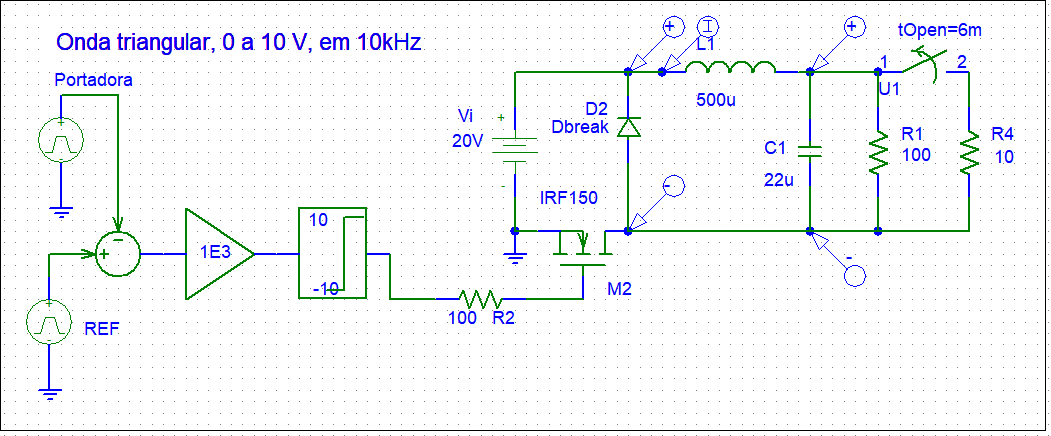

In [2]:
display(Image("cir1.png"))

Circuito em ngspice:

In [37]:
! cat netlist.cir

.model amp gain(gain=1000.0)
.model diff summer(in_gain=[1.0, -1.0] out_gain=1.0)
.model limit limit(out_lowe_limit=-10.0 out_upper_limit=10.0)
.model switch sw(ron=0.1 roff=1e12 vt=0.5 vh=0)

Vpor vn 0 dc 0 pulse(0 10 0 50u 50u 1n 100u)
Vref vp 0 dc 0 pulse(5 6 3m 10n 10n 1s 2s)
a0 [vp vn] 1 diff
a1 1 2 amp
r2 2 g 100
x2 d g 0 irf150
vin vi 0 dc 20
d2 d vi 1n4002
v0 ln vi dc 0
l1 ln lp 500u
c1 d lp 22u
r1 d lp 100
s1 lp rp c1 0 switch On
r4 d rp 10
vc c1 0 pwl(0 1 12m 0)


Como o `ngspice` não possui uma chave analógica controlada temporalmente, foi utilizado uma chave controlada por tensão e uma fonte de tensão que aumenta linearmente (vc que vai de 0 a 1V em 12ms) para abrir a chave s1 em 6ms.

In [29]:
vdiode = np.genfromtxt('data/01-vdiode.csv')
vcap = np.genfromtxt('data/01-vcap.csv')
iind = np.genfromtxt('data/01-iind.csv')
vg = np.genfromtxt('data/01-vg.csv')
vref = np.genfromtxt('data/01-vref.csv')
vport = np.genfromtxt('data/01-vport.csv')

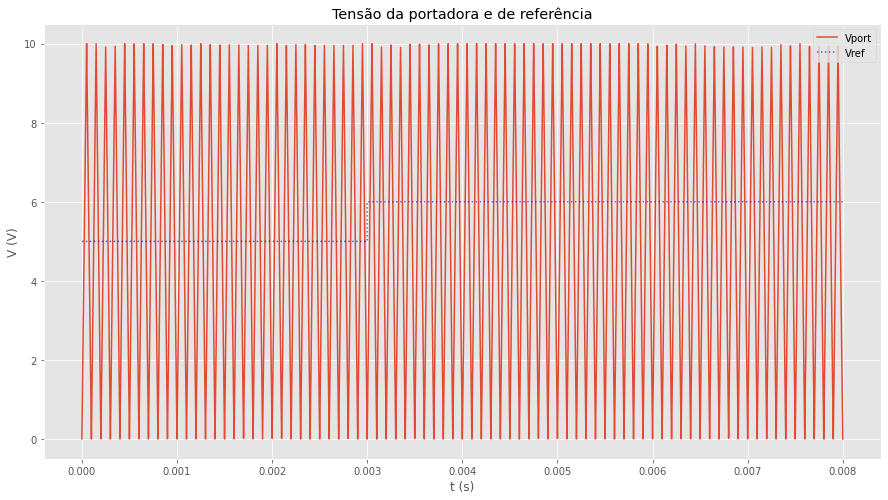

In [26]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)

ax1.plot(vport[:, 0], vport[:,1], )
ax1.plot(vref[:,0], vref[:,1], ':b', alpha=0.6)
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.legend(['Vport', 'Vref'])
plt.title("Tensão da portadora e de referência")
plt.show()


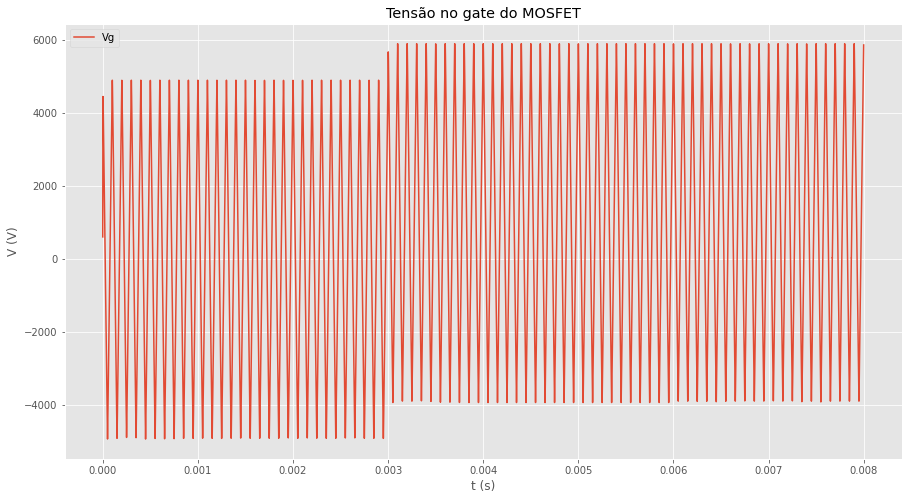

In [27]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vg[:,0], vg[:,1])
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.legend(['Vg', 'Vport', 'Vref'])

plt.title("Tensão no gate do MOSFET")
plt.show()

Nos dois gráficos acima podemos ver como a tensão de referência e a portadora triangular transferem o sinal de controle para o gate do transistor MOSFET, primeiramente centrado em 5V, depois (3ms) em 6V.

<IPython.core.display.Javascript object>


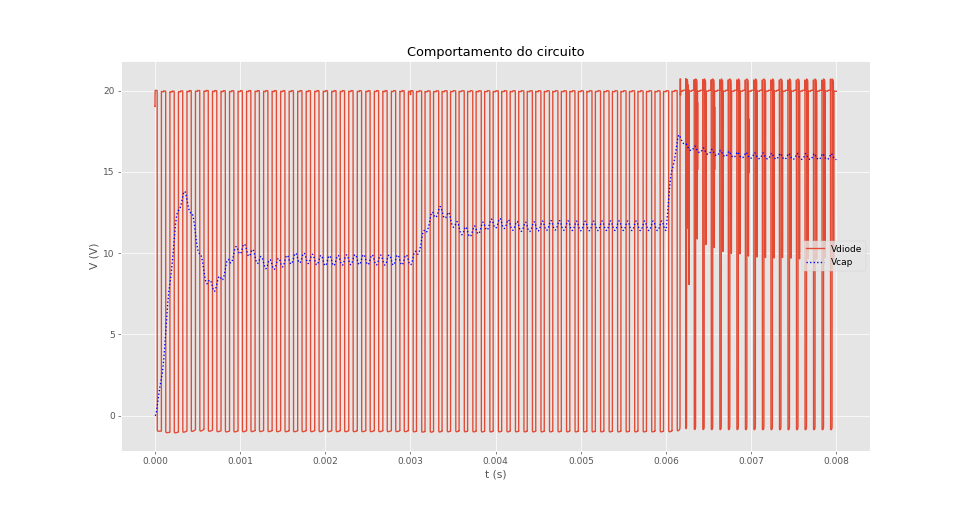

In [35]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vdiode[:,0], vdiode[:,1])
ax1.plot(vcap[:,0], vcap[:,1], ':b')
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.legend(['Vdiode', 'Vcap'])

#ax2 = ax1.twinx()
#ax2.plot(iind[:,0], iind[:,1], '--b', alpha=0.5)
#ax2.set_ylabel("i (A)")
#ax2.legend(['Iind'], loc='lower right')
plt.title("Comportamento do circuito")
plt.show()

Podemos perceber que - inicialmente com uma carga de 9,09 ohm (100 ohm em paralelo com 10 ohm) a tensão no capacitor oscila até estabilizar próxima a 10V, depois de 3ms, quando a referência sobe para 6V, há uma elevação da tensão no capacitor (~12V) que se eleva bruscamente para aproximadamente 16V quando a carga se eleva para 100ohm. Podemos fazer uma análise da tensão no diodo calculando a média utilizando python (o ngspice não possui a função avgx):

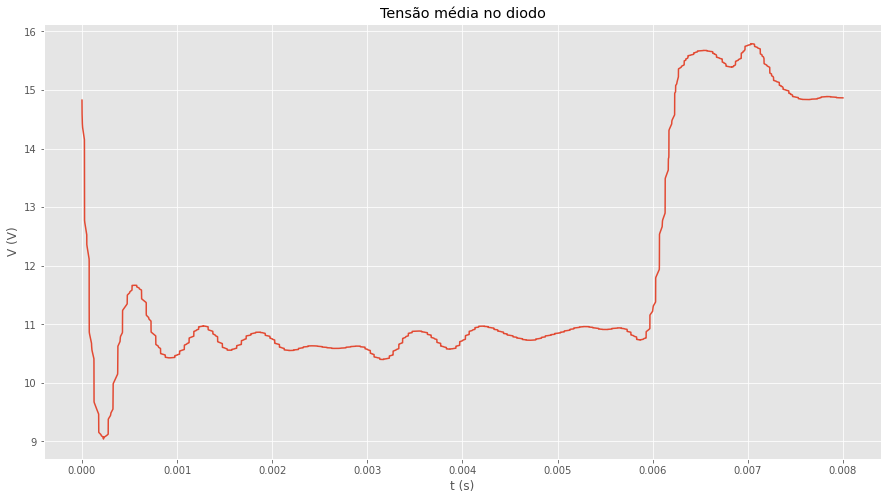

In [31]:
import scipy.signal as signal

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.001 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
smooth_data = signal.filtfilt(B,A, vdiode[:,1])
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vdiode[:,0], smooth_data[:])
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
plt.title('Tensão média no diodo')
plt.show()

Temos um comportamento similar, a tensão oscila de início, se estabiliza próximo a 10,5V, se eleva ao se elevar a tensão de referência e sobe bruscamente ao se aumentar a carga. Podemos perceber então que o indutor está funcionando para suprir as quedas de tensão e retificar o comportamento oscilatório da saída.

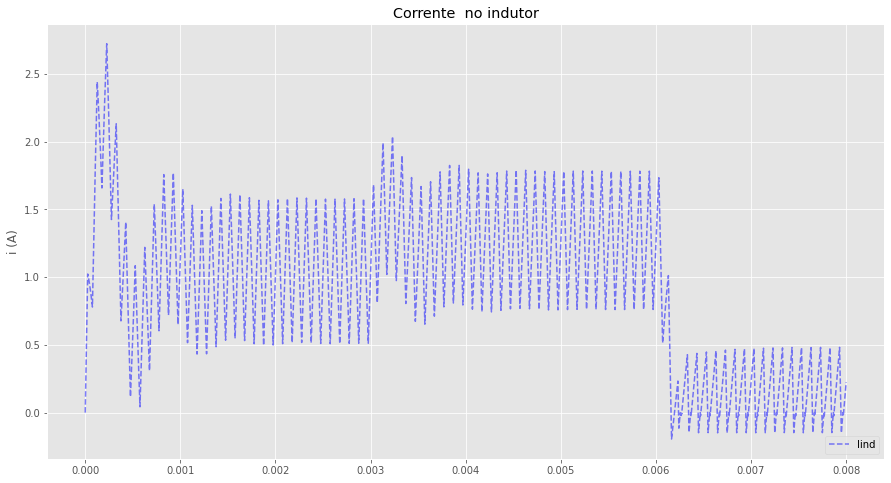

In [32]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(iind[:,0], iind[:,1], '--b', alpha=0.5)
ax1.set_ylabel("i (A)")
ax1.legend(['Iind'], loc='lower right')
plt.title("Corrente  no indutor")
plt.show()

In [36]:
import scipy.signal as signal

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.001 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
smooth_data = signal.filtfilt(B,A, iind[:,1])
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(iind[:,0], smooth_data[:])
ax1.set_ylabel("A (V)")
ax1.set_xlabel("t (s)")
plt.title('Corrente média no indutor')
plt.show()

<IPython.core.display.Javascript object>

Ao se analisar a corrente, como esperado há uma oscilação de corrente inicial por conta da capacitância-indutância do circuito, depois uma estabilização da mesma perto de 1V para a carga de 9,09 ohm e tensões de 5V e 1.25V para referência de 6V. Ao se elevar a carga, há uma queda da corrente, como esperado.

Podemos calcular os valores teóricos de tensão e corrente de saída em cada um dos casos utilizando o dutycycle do sinal que faz o transistor chavear (e que, consequentemente, fará o diodo chavear):

$$
V_o = \delta \cdot E
$$

$$
I_o = \frac{V_o}{R} = \frac{\delta \cdot E}{R}
$$

**0-3ms**:

$V_{o-teorico} = 0.5 \cdot 20 = 10 V$

$I_{o-teorico} = \frac{10}{9.09} = 1.1001 A$

$V_{o-experimental} = 9.57 V$

$I_{o-experimental} = 1.023 A$

$e_V = \frac{V_{o-experimental}}{V_{o-teorico}} = 0.957$

$e_I = \frac{I_{o-experimental}}{I_{o-teorico}} = 0.92992$

**3ms-6ms**:

$V_{o-teorico} = 0.6 \cdot 20 = 12 V$

$I_{o-teorico} = \frac{12}{9.09} = 1.3201 A$

$V_{o-experimental} = 11.77 V$

$I_{o-experimental} = 1.271 A$

$e_V = \frac{V_{o-experimental}}{V_{o-teorico}} = 0.98083$

$e_I = \frac{I_{o-experimental}}{I_{o-teorico}} = 0.96281$

**6ms-8ms**:

$V_{o-teorico} = 0.6 \cdot 20 = 12 V$

$I_{o-teorico} = \frac{12}{100} = 0.12 A$

$V_{o-experimental} = 15.9 V$

$I_{o-experimental} = 0.162 A$

$e_V = \frac{V_{o-experimental}}{V_{o-teorico}} = 1.325$

$e_I = \frac{I_{o-experimental}}{I_{o-teorico}} = 1.35$



Assim, é possível perceber que os valores entregues na saída do conversor são muito próximos dos valores ideais, sobretudo com uma carga baixa. Com a carga mais elevada houve um erro de ~30% em relação aos valores de um conversor ideal.

# Conversor boost (elevador de tensão)

Similar ao circuito anterior, este circuito também é um conversor CC utilizando um transistor, um diodo, um capacitor e um indutor. Mas desta vez o objetivo é ter uma tensão de saída mais elevada (por mais que implique numa capacidade de fornecer menos corrente).

In [136]:
display(Image("cir2.png"))

Circuito em ngspice:

In [137]:
! cat netlist2.cir

Ve d 0 dc 7
L1 0 s 1m
Vg s g dc 0 PULSE(-10 10 0 10n 10n 50u 100u)
x1 s g d1 IRF150
v1 d1 d dc 0
d1 d v1 1N4002
vout vo v1 dc 0
c1 s vo 22u
r1 s vo 10


O circuito funciona da seguinte forma. Enquanto o transistor T está conduzindo, a corrente percorre o ramo do transistor e, assim, a saída total (tensão no capacitor + indutor) é E. Quando o transistor para de conduzir, o indutor impede a corrente reversa que surgiria em direção ao capacitor. Assim, soma-se, ao valor de tensao no indutor (E) o valor no capacitor (Vo), desta forma, a tensão de saída total é E + Vo.

In [58]:
display(Image("vind.png"))

Quando T conduz (por $t_T$): $V_L=E$

Quando D conduz (por $\tau - t_T$): $V_L=E-V_o$

$$
E \cdot t_T = (V_o - E)\cdot(\tau - t_T)
$$

$$
\frac{V_o}{E} = \frac{1}{1-\delta}
$$

Com os dados apresentados no enunciado do exercício e com as notas de aula, podemos calcular:

$I_o = \frac{V_o}{R_o} = 1 A$

$I_i = \frac{V_o \cdot I_o}{E} = 1.4286 A$

$\Delta I_i = \frac{E \cdot t_T}{L} = \frac{\tau \cdot \delta}{L} = \frac{\frac{1}{RC} \cdot (1 - \frac{E}{V_o})}{L} = 0.03 A$

In [59]:
display(Image("graficos.png"))

Por fim, o circuito foi simulado, mas apresentou um comportamento inesperado, com uma corrente cada vez maior no diodo e uma tensão cada vez maior nos terminais do transistor e do resistor.

In [55]:
vds = np.genfromtxt('data/02-vds.csv')
ids = np.genfromtxt('data/02-id.csv')
io = np.genfromtxt('data/02-io.csv')
vo = np.genfromtxt('data/02-vo.csv')

In [56]:

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(vds[:,0], vds[:,1])
ax1.plot(vo[:,0], vo[:,1])
ax1.set_ylabel("V (V)")
ax1.set_xlabel("t (s)")
ax1.set_ylim([0,2.5])
ax1.legend(['Vds', 'Vo'])

ax2 = ax1.twinx()
ax2.plot(ids[:,0], ids[:,1], '--b', alpha=0.8)
ax2.plot(io[:,0], io[:,1], ':g', alpha=0.8)
ax2.set_ylabel("i (A)")
ax2.legend(['Id', 'Io'], loc='lower right')
plt.title("Comportamento do circuito")
plt.show()

<IPython.core.display.Javascript object>

# Anexos {-}

Arquivos utilizados e gerados para e na simulação:

In [38]:
%%bash
echo "Modelo de transistor MOS:"
echo ""
echo "irf150.cir:"
echo "======="
echo ""
cat ../models/irf150.cir

Modelo de transistor MOS:

irf150.cir:

* from: http://www.irf.com/part/100V-SINGLE-N-CHANNEL-HI-REL-MOSFET-IN-A-TO-204AE-PACKAGE/_/A~IRF150 

.SUBCKT irf150 1 2 3
**************************************
*      Model Generated by MODPEX     *
*Copyright(c) Symmetry Design Systems*
*         All Rights Reserved        *
*    UNPUBLISHED LICENSED SOFTWARE   *
*   Contains Proprietary Information *
*      Which is The Property of      *
*     SYMMETRY OR ITS LICENSORS      *
*Commercial Use or Resale Restricted *
*   by Symmetry License Agreement    *
**************************************
* Model generated on Dec 17, 96
* MODEL FORMAT: SPICE3
* Symmetry POWER MOS Model (Version 1.0)
* External Node Designations
* Node 1 -> Drain
* Node 2 -> Gate
* Node 3 -> Source
M1 9 7 8 8 MM L=100u W=100u
* Default values used in MM:
* The voltage-dependent capacitances are
* not included. Other default values are:
*   RS=0 RD=0 LD=0 CBD=0 CBS=0 CGBO=0
.MODEL MM NMOS LEVEL=1 IS=1e-32
+VTO=4.07861 LAMBD

In [39]:
%%bash
echo "ex1.cir"
echo "======="
echo ""
cat ex1.cir

ex1.cir

DC-DC conversor

* OPTIONS
.option TEMP=27C
.option METHOD=GEAR

* CONTROL
.control
tran 1u 8m uic

option numdgt=4
wrdata data/01-sw.csv vr(rp)
wrdata data/01-vdiode.csv vr(ln)-vr(d)
wrdata data/01-iind.csv -i(v0)
wrdata data/01-vcap.csv vr(lp)-vr(d)
wrdata data/01-vg.csv vr(g)
wrdata data/01-vport.csv vr(vn)
wrdata data/01-vref.csv vr(vp)

.endc

* END
.end


In [40]:
%%bash
echo "01.out"
echo "======="
echo ""
cat data/01.out

01.out


Circuit: dc-dc conversor

Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using transient initial conditions
Note: No ".plot", ".print", or ".fourier" lines; no simulations run

No. of Data Rows : 31948


In [41]:
%%bash
echo "ex2.cir"
echo "======="
echo ""
cat ex2.cir

ex2.cir

DC-DC conversor

* OPTIONS
.option TEMP=27C
.option METHOD=GEAR

* CONTROL
.control
tran 1u 6m uic

option numdgt=4
wrdata data/02-vds.csv vr(d1)-vr(s)
wrdata data/02-id.csv -i(v1)
wrdata data/02-io.csv -i(vout)
wrdata data/02-vo.csv vr(vo)-vr(s)
.endc

* END
.end


In [42]:
%%bash
echo "02.out"
echo "======="
echo ""
cat data/02.out

02.out


Circuit: dc-dc conversor

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using transient initial conditions
Note: No ".plot", ".print", or ".fourier" lines; no simulations run

No. of Data Rows : 12397
